In [1]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text as sql_text

load_dotenv()

conn = create_engine(
    f"postgresql://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}@{os.getenv('PG_HOST')}/{os.getenv('PG_DBNAME')}"
).connect()

In [2]:
import pandas as pd

temp_readings = pd.read_sql_query(sql_text("SELECT * FROM public.temp_readings"), conn)
fire_alerts = pd.read_sql_query(sql_text("SELECT * FROM public.fire_alerts"), conn)
tweets = pd.read_sql_query(sql_text("SELECT * FROM public.tweets"), conn)

In [3]:
temp_readings

,day,xy,temperature,id
0,2226,"(2,0)",72,2002560
1,2226,"(2,1)",75,2002561
2,2226,"(2,2)",95,2002562
3,2226,"(2,3)",78,2002563
4,2226,"(2,4)",82,2002564
...,...,...,...,...
2294094,2226,"(1,25)",73,2002555
2294095,2226,"(1,26)",78,2002556
2294096,2226,"(1,27)",84,2002557
2294097,2226,"(1,28)",96,2002558


In [4]:
tweets

,day,xy,score,content,id
0,1,"(0,5)",None,to his brothers commanded him to remain succee...,0
1,1,"(0,5)",None,country to surat might go from thence to basso...,1
2,1,"(0,5)",None,to it was obliged to let it lie where it was a...,2
3,1,"(0,5)",None,found cure both for soul and body opened the c...,3
4,1,"(0,6)",None,means indeed the russians travel more in winte...,4
...,...,...,...,...,...
1711158,2549,"(29,27)",None,of her own mamma she was thoughtful for moment...,1711158
1711159,2549,"(29,27)",None,boat with orders to secure her and bring away ...,1711159
1711160,2549,"(29,27)",None,for the expedition ernest begged to be of the ...,1711160
1711161,2549,"(29,27)",None,in order to act the rebel to their authority a...,1711161


In [5]:
fire_alerts

,event_day,notification_day,xy,id
0,29,32,"(1,25)",0
1,34,37,"(9,24)",1
2,38,41,"(20,24)",2
3,39,42,"(0,23)",3
4,39,42,"(28,7)",4
...,...,...,...,...
5600,2332,2335,"(27,7)",5600
5601,2333,2336,"(0,2)",5601
5602,2334,2337,"(13,9)",5602
5603,2340,2343,"(2,17)",5603


# Experiment #1: Predicting fire alerts using temperature readings

Every sector at every day has a temperature reading, while only some sectors have messages. To start, we'll try to predict fire alerts on the day of using temperature readings only from the past 7 days.


In [6]:
from tqdm.notebook import tqdm


def rolling_samples(series, window=7):
    output = []
    for i in range(window, len(series)):
        sample = series[i - window : i].tolist()
        output.append((sample, i))
    return output


samples = []
for name, group in tqdm(temp_readings.groupby("xy")):
    group = group.sort_values("day")
    events = fire_alerts[fire_alerts["xy"] == name]["event_day"].values
    temps = rolling_samples(group["temperature"].set_axis(group["day"]))

    for temp, i in temps:
        samples.append((temp, 1 if i in events else 0))

  0%|          | 0/900 [00:00<?, ?it/s]

In [7]:
import numpy as np

samples_x, samples_y = zip(*samples)
samples_x, samples_y = np.array(samples_x), np.array(samples_y)

len(samples_x)

2287799

In [8]:
samples_x

array([[54, 47, 59, ..., 56, 54, 55],
       [47, 59, 61, ..., 54, 55, 48],
       [59, 61, 56, ..., 55, 48, 41],
       ...,
       [35, 20, 42, ..., 40, 47, 43],
       [20, 42, 33, ..., 47, 43, 30],
       [42, 33, 40, ..., 43, 30, 47]])

In [9]:
samples_y

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(samples_x, samples_y, test_size=0.2)

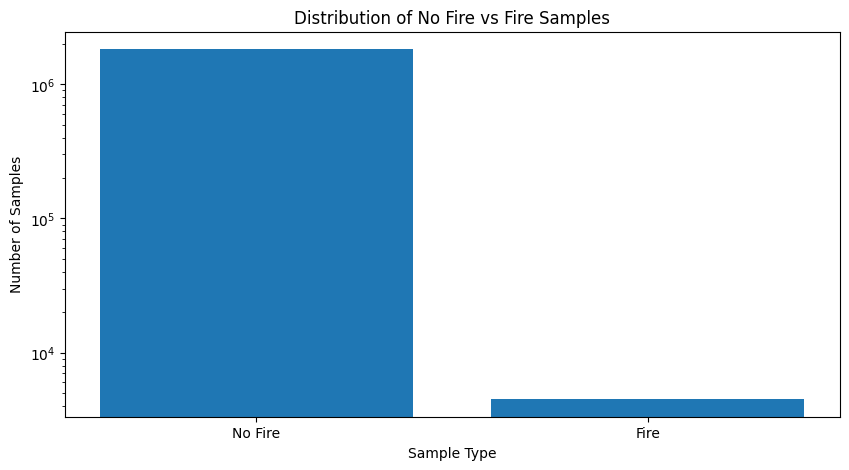

In [11]:
# plot distribution of samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(["No Fire", "Fire"], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title("Distribution of No Fire vs Fire Samples")
plt.xlabel("Sample Type")
plt.ylabel("Number of Samples")
plt.yscale("log")
plt.show()

In [12]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# correct any imbalance before training
# smoteenn = SMOTEENN()
# train_x, train_y = smoteenn.fit_resample(train_x, train_y)

smote = SMOTE()
train_x, train_y = smote.fit_resample(train_x, train_y)

# rus = RandomUnderSampler()
# train_x, train_y = rus.fit_resample(train_x, train_y)

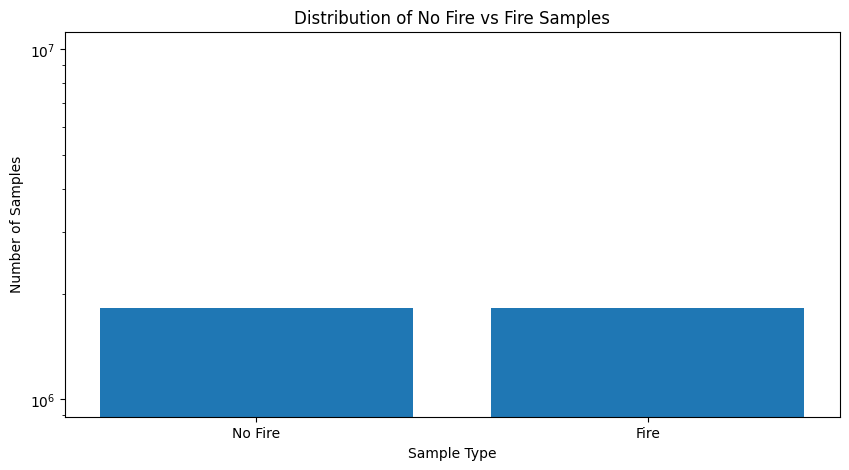

In [13]:
# let's plot after fixing it now
plt.figure(figsize=(10, 5))
plt.bar(["No Fire", "Fire"], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title("Distribution of No Fire vs Fire Samples")
plt.xlabel("Sample Type")
plt.ylabel("Number of Samples")
plt.yscale("log")
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler


# function to preprocess our data
def preprocess_train(x_data, y_data):
    x_scaler = StandardScaler()
    x_data = x_scaler.fit_transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data, x_scaler


def preprocess_test(x_data, y_data, x_scaler):
    x_data = x_scaler.transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data

In [15]:
import pickle

train_x, train_y, scaler = preprocess_train(train_x, train_y)
test_x, test_y = preprocess_test(test_x, test_y, scaler)

# save the scaler for future use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [16]:
from keras import Sequential
from keras.layers import Dense


# implement a simple neural network
def build_model(length_x):
    model = Sequential(
        [
            Dense(512, activation="swish", input_shape=(length_x,)),
            Dense(2, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

2023-08-08 21:44:22.027116: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:44:22.159917: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [17]:
from keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )
]

dnn_model = build_model(len(samples_x[0]))

dnn_model.fit(
    train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=2048,
    validation_split=0.2,
    verbose=1,
)

2023-08-08 21:44:23.696202: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:44:24.019991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Epoch 1/100
1427/1427 [==============================] - 8s 5ms/step - loss: 0.0572 - accuracy: 0.9808 - val_loss: 0.0236 - val_accuracy: 0.9935
Epoch 2/100
1427/1427 [==============================] - 7s 5ms/step - loss: 0.0336 - accuracy: 0.9888 - val_loss: 0.0364 - val_accuracy: 0.9879
Epoch 3/100
1427/1427 [==============================] - 7s 5ms/step - loss: 0.0325 - accuracy: 0.9892 - val_loss: 0.0280 - val_accuracy: 0.9915
Epoch 4/100
1427/1427 [==============================] - 7s 5ms/step - loss: 0.0295 - accuracy: 0.9904 - val_loss: 0.0169 - val_accuracy: 0.9967
Epoch 5/100
1427/1427 [==============================] - 7s 5ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0262 - val_accuracy: 0.9931
Epoch 6/100
1427/1427 [==============================] - 6s 4ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0165 - val_accuracy: 0.9964
Epoch 6: early stopping


In [18]:
dnn_model.evaluate(test_x, test_y, batch_size=512, return_dict=True)

894/894 [==============================] - 3s 3ms/step - loss: 0.0288 - accuracy: 0.9903


{'loss': 0.028765801340341568, 'accuracy': 0.990300714969635}

In [19]:
# calculate the accuracy if we always predict [1, 0] to be the output
from sklearn.metrics import accuracy_score
import random

random_predictions = [random.choice([[0, 1], [1, 0]]) for _ in range(len(test_y))]

accuracy_score(test_y, np.array(random_predictions))

0.4996678031296442

In [20]:
# find the index of a [0, 1] example in the test y and predict it
idx = np.where(test_y == [0, 1])[0][0]
dnn_model.predict(test_x[idx : idx + 1])

1/1 [==============================] - 0s 92ms/step


array([[0.02222086, 0.97777915]], dtype=float32)

The model is able to be very accurate, but this relies purely on temperature data. Before we move on to NLP and text analysis, let's try implementing an LSTM for this problem


# Experiment #2: Predicting fire alerts using temperature readings with an LSTM

The LSTM will take in the temperature readings from the past 7 days and output a prediction for the 7th day.


In [21]:
lstm_train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
lstm_test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [22]:
from keras.layers import LSTM


def build_lstm_model(length_x):
    model = Sequential(
        [
            LSTM(50, activation="swish", input_shape=(length_x, 1)),
            Dense(2, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [23]:
lstm_model = build_lstm_model(len(samples_x[0]))

lstm_model.fit(
    lstm_train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=4096,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
714/714 [==============================] - 16s 20ms/step - loss: 0.1994 - accuracy: 0.9187 - val_loss: 0.0408 - val_accuracy: 0.9919
Epoch 2/100
714/714 [==============================] - 15s 21ms/step - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.0371 - val_accuracy: 0.9901
Epoch 3/100
714/714 [==============================] - 14s 20ms/step - loss: 0.0284 - accuracy: 0.9912 - val_loss: 0.0107 - val_accuracy: 0.9983
Epoch 4/100
714/714 [==============================] - 14s 20ms/step - loss: 0.0247 - accuracy: 0.9924 - val_loss: 0.0090 - val_accuracy: 0.9986
Epoch 5/100
714/714 [==============================] - 15s 21ms/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0581 - val_accuracy: 0.9808
Epoch 6/100
714/714 [==============================] - 15s 21ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0155 - val_accuracy: 0.9971
Epoch 7/100
714/714 [==============================] - 15s 21ms/step - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0266 - val_ac

In [24]:
lstm_model.evaluate(lstm_test_x, test_y, batch_size=4096, return_dict=True)

112/112 [==============================] - 1s 7ms/step - loss: 0.0323 - accuracy: 0.9890


{'loss': 0.03229280933737755, 'accuracy': 0.9889588356018066}

In [25]:
idx = np.where(test_y == [0, 1])[0][0]
lstm_model.predict(test_x[idx : idx + 1])

1/1 [==============================] - 0s 253ms/step


array([[0.01444654, 0.98555344]], dtype=float32)

In [26]:
# save our two temperature models
dnn_model.save("dnn_model.h5")
lstm_model.save("lstm_model.h5")

# Experiment #3: Using a pretrained sentiment analysis model

We will try to use a pretrained sentiment analysis model, BERT, to predict if a tweet relates to a fire or not.


In [3]:
# output all tweets that occur at the date and location of a fire event
# first, get all the dates and locations of fire events
fires = []

for i, row in fire_alerts.iterrows():
    fires.append((row["event_day"], row["xy"]))

In [5]:
from tqdm.notebook import tqdm

# then, get all the tweets that occur at the date and location of a fire event
tqdm.pandas()

fire_tweets = tweets.progress_apply(
    lambda row: (row["day"], row["xy"]) in fires, axis=1
)

  0%|          | 0/1711163 [00:00<?, ?it/s]

In [6]:
fire_samples = tweets.loc[fire_tweets]
not_fire_samples = tweets.loc[~fire_tweets]

In [7]:
tweet_samples_x = (
    fire_samples["content"].values.tolist()
    + not_fire_samples["content"].values.tolist()
)
tweet_samples_y = [1] * len(fire_samples) + [0] * len(not_fire_samples)

In [8]:
# preprocess our data
# we need to split our data into train and test sets first
# then we need to correct any class imbalance
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    tweet_samples_x, tweet_samples_y, test_size=0.2, stratify=tweet_samples_y
)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, stratify=train_y
)

In [9]:
from datasets import Dataset, Features, Value, ClassLabel, DatasetDict

features = Features(
    {
        "text": Value("string"),
        "label": ClassLabel(num_classes=2, names=["no_fire", "yes_fire"]),
    }
)

dataset = DatasetDict(
    {
        "train": Dataset.from_dict(
            {"text": train_x, "label": train_y}, features=features
        ),
        "test": Dataset.from_dict({"text": test_x, "label": test_y}, features=features),
        "validation": Dataset.from_dict(
            {"text": val_x, "label": val_y}, features=features
        ),
    }
)

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=300
    )


tokenized_datasets = dataset.map(tokenize_function, batched=True).remove_columns("text")

Map:   0%|          | 0/1095144 [00:00<?, ? examples/s]

Map:   0%|          | 0/342233 [00:00<?, ? examples/s]

Map:   0%|          | 0/273786 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1095144
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 342233
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 273786
    })
})

In [12]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "no_fire", 1: "yes_fire"}
label2id = {"no_fire": 0, "yes_fire": 1}

# model should be trained by now, see train-bert.py for details
model = AutoModelForSequenceClassification.from_pretrained(
    "./blaze_nlp", num_labels=2, id2label=id2label, label2id=label2id
)

2023-08-08 23:34:08.084330: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 23:34:08.237574: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [13]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import transformers as tfm
import numpy as np
import evaluate
import logging
import sys


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)
tfm.logging.set_verbosity_info()

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    auto_find_batch_size=True,
    report_to="none",
    # save_safetensors=True,
    per_device_eval_batch_size=512,
)
metric = evaluate.load("accuracy")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["validation"].shuffle(seed=42),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

using `logging_steps` to initialize `eval_steps` to 500
Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!


PyTorch: setting up devices


In [14]:
import torch

torch.cuda.empty_cache()

# evaluate the model
evaluation = trainer.evaluate(tokenized_datasets["test"])

print(evaluation)

***** Running Evaluation *****
  Num examples = 342233
  Batch size = 512


{'eval_loss': 0.016885794699192047, 'eval_accuracy': 0.9976653332671016, 'eval_runtime': 2818.9202, 'eval_samples_per_second': 121.406, 'eval_steps_per_second': 0.237}


In [15]:
# grab two ranom examples, one with yes and one with no
# grab two random examples, one with yes and one with no
yes_idxs = np.where(np.array(test_y) == 1)[0]
no_idxs = np.where(np.array(test_y) == 0)[0]

yes_idx = yes_idxs[np.random.randint(len(yes_idxs))]
no_idx = no_idxs[np.random.randint(len(no_idxs))]

print(test_x[yes_idx])

undertaken it but convinced him first that his undertaking was impracticable in itself and secondly that perhaps would put it into way of being done in his absence to his satisfaction having thus brought the affairs of the


In [16]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="./blaze_nlp")

loading configuration file ./blaze_nlp/config.json
Model config BertConfig {
  "_name_or_path": "./blaze_nlp",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "no_fire",
    "1": "yes_fire"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "no_fire": 0,
    "yes_fire": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./blaze_nlp/config.json
Model config BertConfig {
  "_name

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
print(test_x[no_idx])
classifier(test_x[no_idx])

had caught branch and swung myself out and plunged into the nearest thicket while silver and the rest were still hundred yards behind jim jim heard him shouting but you


[{'label': 'no_fire', 'score': 0.9987927675247192}]

In [18]:
print(test_x[yes_idx])
classifier(test_x[yes_idx])

undertaken it but convinced him first that his undertaking was impracticable in itself and secondly that perhaps would put it into way of being done in his absence to his satisfaction having thus brought the affairs of the


[{'label': 'no_fire', 'score': 0.9987924098968506}]